# Домашнее задание №11: Разные способы применения PointNet

План выполнения работы:

- Обучите PointNet
- Напишите функцию, которая находит набор критических точек для объекта, сделайте визуализацию нескольких примеров (определение критической точки - раздел 4.3 в статье)
- Напишите функцию, которая ищет похожие объекты по вектору global features (см. раздел E дополнительных материалов к статье).
- Напишите функцию, которая выполняет операцию shape correspondence для двух объектов одного класса по набору критических точек (см. раздел E дополнительных материалов к статье)

Ссылка на статью PointNet: https://arxiv.org/pdf/1612.00593.pdf

In [1]:
import os
from copy import deepcopy

import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import Image

from pointnet_lib import read_off
from pointnet_lib import PointCloudDataset, PointCloudDatamodule, PointNet
from pointnet_lib import PointSampler, Normalize, RandRotation_z, RandomNoise, ToTensor, default_transforms

SEED = 2022

## 1 Предобработка данных датасета

В качестве датасета будем использовать архив http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Датасет содержит 10 классов. Каждый объект в датасете описан с помощью формата Object File Format и имеет файл с расширением off.

Укажем путь к распакованному датасету:

In [2]:
dataset_root = "ModelNet10"

Выведем список названий классов в датасете:

In [3]:
folders = [class_dir for class_dir in sorted(os.listdir(dataset_root)) if os.path.isdir(os.path.join(dataset_root, class_dir))]
classes = {folder: i for i, folder in enumerate(folders)};
for class_name, idx in classes.items():
    print(f"{idx+1}. {class_name}")

1. bathtub
2. bed
3. chair
4. desk
5. dresser
6. monitor
7. night_stand
8. sofa
9. table
10. toilet


Получим координаты вершин точек и их грани одного объекта кровати с помощью функции read_off:

In [4]:
with open(dataset_root + "/bed/train/bed_0001.off", 'r') as f:
    verts, faces = read_off(f)
verts = np.array(verts)

Визуализируем полученные вершины фигуры:

In [5]:
def plot_point_cloud(points):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    plt.show()

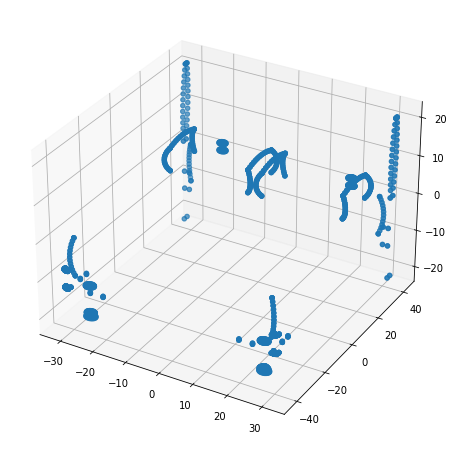

In [6]:
plot_point_cloud(verts)

На графике мы видим только вершины фигуры спальной кровати. В таком виде мы не можем подавать данные в нашу модель, так как только по вершинам опознать объект невозможно. Требуется создать облако точек, которые заполнят полости нашей фигуры. Для этого воспользуемся классом PointSampler:

In [7]:
point_sampler = PointSampler(1024)
point_cloud = point_sampler([verts, faces])

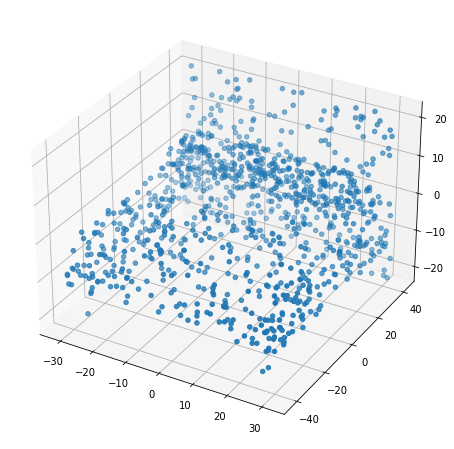

In [8]:
plot_point_cloud(point_cloud)

Теперь мы получили объемное облако точек, которое уже напоминает результаты работы объемных сенсоров. И такие данные уже можно подавать в модель PointNet для обучения. 

Также для тестовых и валидационных данных будем применять операцию нормализации координат с помощью класса Normalize:

In [9]:
normalize = Normalize()
point_cloud_norm = normalize(point_cloud)

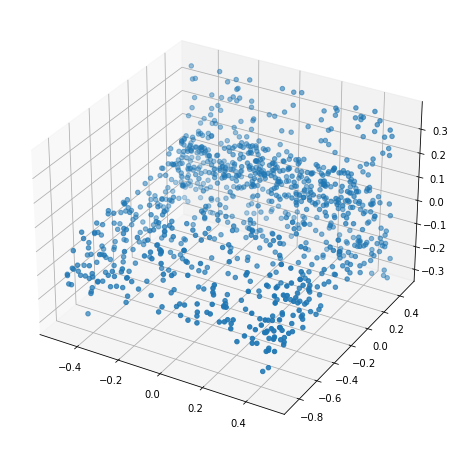

In [10]:
plot_point_cloud(point_cloud_norm)

А для обучающих данных будем выполнять аугментацию в виде добавления небольшого случайного шума и поворота по оси Z:

In [11]:
rand_rotation = RandRotation_z()
rand_noise = RandomNoise()

point_cloud_norm_aug = rand_noise(rand_rotation(point_cloud_norm))

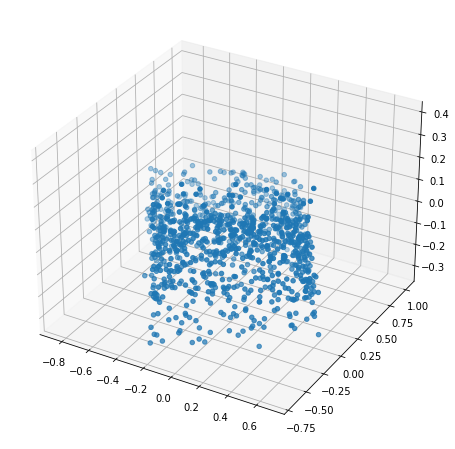

In [12]:
plot_point_cloud(point_cloud_norm_aug)

Для генерации данных модели реализованы классы PointCloudDataset и PointCloudDatamodule. PointCloudDataset открывает описание объектов, сэмплирует дополнительные точки и выполняет аугментацию. И позволяет получить готовое облако точек, идентификатор класса и путь к исходному файлу координат объекта.

Сформируем пайплайн для аугментации данных обучения:

In [13]:
train_transforms = transforms.Compose([
    PointSampler(1024),
    Normalize(),
    RandRotation_z(),
    RandomNoise(),
    ToTensor()
])

Для тестовой части данных будет использоваться аналогичный пайплайн преобразований, кроме случайного поворота и шума.

## 2 Обучение модели классификации PointNet

Для обучения модели подготовлены классы TNet, Transform и PointNet. Основной моделью для обучения является PointNet.

Класс TNet реализует блок T-Net из статьи и возвращает в прямом проходе матрицу поворота. 
Класс Transform реализует часть PointNet от принятия входных данных до блока MaxPool классификатора.
Класс PointNet является законченной моделью классификатора, которая использует вышеописанные классы.

Класс PointNet позволяет в прямом проходе получить логиты классов, матрицы поворота, эмбеддинги классификатора после слоя MaxPool и критические точки.

На рисунке ниже приведена полная архитектура модели PointNet. В данной домашней работе реализована только сеть классификации.

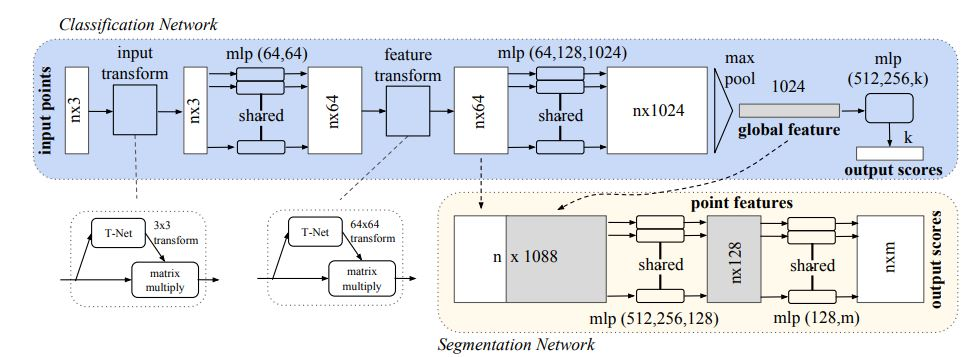

In [14]:
Image('tmp/pointnet_architecture.jpg')

Подготовим конфигурацию и обучим модель:

In [15]:
config = {
    'seed': SEED,
    'model': {
        'classes': 10,
        'plot_epoch_loss': True,
        'dropout': 0.5,
        'learning_rate': 0.0005, 
        'l2_regularization': 0.01,
        'adam_betas': (0.99, 0.999),
        'seed': SEED,
    },
    'trainer': {
        'max_epochs': 40,
        'gpus': 1 if torch.cuda.is_available() else 0,
        'resume_from_checkpoint': None,
    },
    'datamodule': {
        'seed': SEED,
        'root_dir': dataset_root,
        'train_transforms': train_transforms,
        'train_loader_params': {
            'batch_size': 64,
            'shuffle': True,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': True,
        },
        'val_loader_params': {
            'batch_size': 128,
            'shuffle': False,
            'num_workers': 0,
            'pin_memory': False,
            'drop_last': False
        },
    },
}

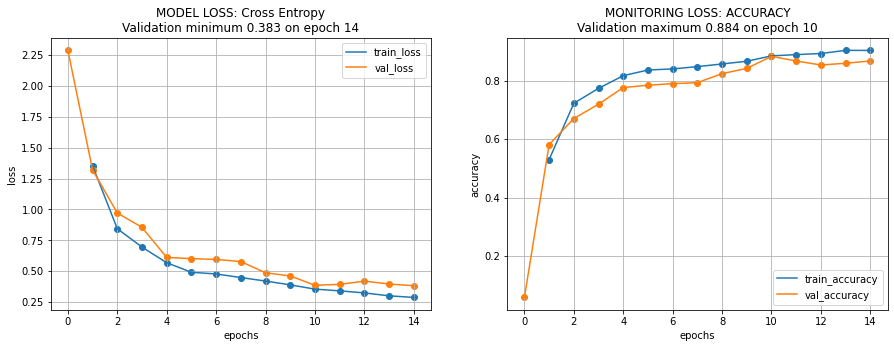

In [16]:
# Если False, то будут загружены предобученные веса из файла pointnet_best.pth
TRAIN_MODEL = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if TRAIN_MODEL:

    model = PointNet(**config['model'])
    datamodule = PointCloudDatamodule(**config['datamodule'])
    checkpoint = ModelCheckpoint(dirpath='checkpoint_model/', monitor='val_accuracy', mode='max')

    callbacks = [
                EarlyStopping('val_accuracy', min_delta=0.001, patience=3, mode='max'),
                TQDMProgressBar(refresh_rate=1),
                checkpoint
    ]

    trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)
    
    trainer.fit(model, datamodule)
    
    model = PointNet.load_from_checkpoint(checkpoint.best_model_path)
    model = model.to(device)

    torch.save(model.state_dict(), 'pointnet_best.pth')
    
else:
    
    model = PointNet(**config['model'])
    model.load_state_dict(torch.load('pointnet_best.pth'))
    model = model.to(device)
    
_ = model.eval()

По графикам обучения модели можно сказать, что она обучалась стабильно и без переобучения. 

Посмотрим матрицу ошибок на тестовом датасете

In [17]:
def print_confusion_matrix(cf_matrix, target_names):
    """ Печать матрицы ошибок с heatmap
    
    Параметры
    ---------
    cf_matrix : np.ndarray
      Матрица ошибок
    target_names : list
      Список имен для признаков
    """
    
    plt.figure(figsize=(14,7))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names)

    plt.show()

In [18]:
y_pred = []
y_val = []

datamodule = PointCloudDatamodule(**config['datamodule'])
datamodule.val_loader_params['batch_size'] = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for batch in tqdm(datamodule.val_dataloader()):
    
    pointcloud = batch['pointcloud'].to(device)
    logits, matrix3x3, matrix64x64, embeddings, crit_points_idx = model(pointcloud)
    
    predict_class_id = torch.argmax(logits).cpu().item()
    y_pred.append(predict_class_id)
    y_val.append(batch['target'].item())
    
y_pred = np.hstack(y_pred)
y_val = np.hstack(y_val)

  0%|          | 0/908 [00:00<?, ?it/s]

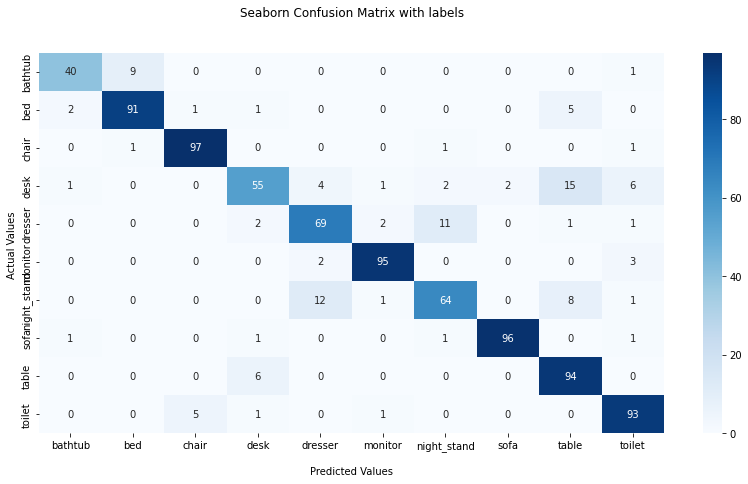

In [19]:
cf_matrix = confusion_matrix(y_val, y_pred)
print_confusion_matrix(cf_matrix, target_names=datamodule.val_dataset._classes.keys())

Получили достаточно хорошую диагональную матрицу ошибок. В целом классы определяем корректно, но иногда можем перепутать desk и table, dresser и night stand.

## 3 Решение дополнительных задач
### 3.1 Визуализация критических точек

Критическая точка - это точка, которая вносит вклад в вектор global feature после операции Max Pooling. До блока Max Pooling координаты точек подвергаются преобразованиям со стороны различных обучающихся блоков. Max Pooling формирует признаки global feature в разрезе точек. В каждую позицию вектора может попасть только одна точка из всего набора. Но при этом на разные позиции глобального ветктора признаков может повлиять одна и та же точка. Если данные точки попали в global feature, то это значит она является значимой для классификации и является критической.

Ниже приведена иллюстрация наборов критических точек:

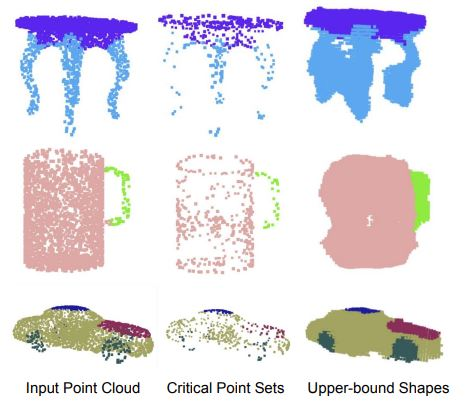

In [20]:
Image('tmp/critical_points.jpg')

Для классификации объекта достаточно передать в сеть его критические точки. Ка видно из изображений, критические точки находятся в тех местах, которые определяют структуру объекта. Например, на изгибах, углах и др.

В данном разделе требуется визуализировать критические точки на тестовом датасете и на практике подтвердить данное утверждение.

In [21]:
def load_point_cloud(path):
    """ Получение облака точек для объект
    К облаку применяются преобразования, которые использовались при валидации модели
    
    Параметры
    ---------
    path : str
      Путь к файлу в формате .off
      
    Результат
    ---------
    point_cloud : torch.tensor
      Тензор размером (1024, 3)
    """
    
    with open(path, 'r') as f:
        verts, faces = read_off(f)
        
    point_cloud = default_transforms()([verts, faces])
    
    return point_cloud

In [22]:
def plot_critical_points(point_cloud, critical_points):
    """ Иллюстрация критических точек в 3D и 2D форматах
    
    Параметры
    ---------
    point_cloud : np.ndarray
      Облако точек размером (N x 3)
    critical_points : np.ndarray
      Массив критических точек размером (С x 3)
    """
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(point_cloud[:,
                           0], point_cloud[:, 1], point_cloud[:, 2], c='b')
    ax.scatter(critical_points[:, 0], critical_points[:, 1], critical_points[:, 2], c='r', marker="*", s=200)
    
    ax = fig.add_subplot(122)
    ax.scatter(point_cloud[:, 1], point_cloud[:, 2])
    ax.scatter(crit_points[:, 1], crit_points[:, 2], marker='*', c='r')
    
    plt.show()

Для визуализации возьмем 2 объекта: унитаз и рабочий стол. Получим и визуализируем критические точки в 2D и 3D форматах:

/toilet/test/toilet_0348.off
Кол-во критических точек: 39


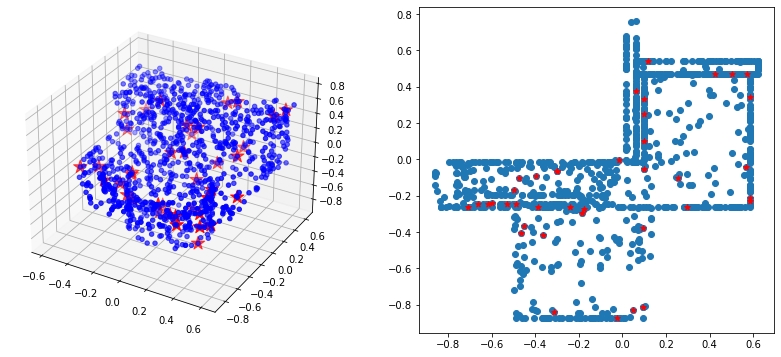

/desk/test/desk_0204.off
Кол-во критических точек: 52


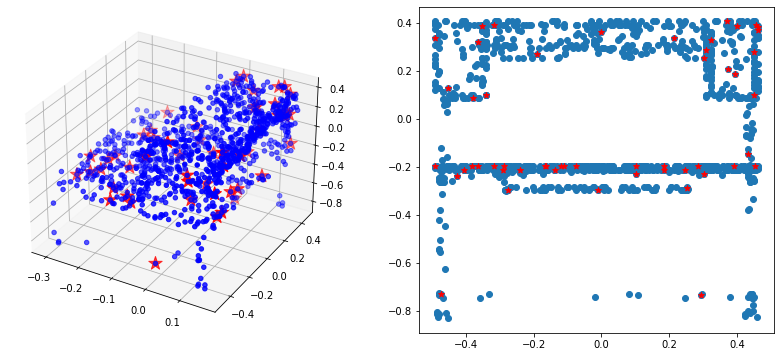

In [23]:
point_sampler=PointSampler(1024)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for object_path in ('/toilet/test/toilet_0348.off', "/desk/test/desk_0204.off"):
    
    print(object_path)
    full_object_path = dataset_root + object_path
    point_cloud = load_point_cloud(full_object_path)
    
    # Добавляем размерность для батча
    point_cloud = point_cloud.unsqueeze(dim=0).to(device)
    
    logits, matrix3x3, matrix64x64, embeddings, crit_points_idx = model(point_cloud)
    point_cloud = point_cloud[0].cpu().numpy()
    crit_points = point_cloud[crit_points_idx.cpu().unique(), :]
    print('Кол-во критических точек:', len(crit_points))
    
    plot_critical_points(point_cloud, crit_points)

Критические точки обозначены красным цветом. Как видно из результата, они действительно в большинстве случаев располагаются гранях объектов.


### 3.2 Поиск похожих предметов с помощью эмбеддингов

Авторы статьи утверждают, что модель классификации умеет хорошо извлекать признаки из облака точек в слое global feature. В своей статье авторы с помощью обученной на тестовых эмбеддингах модели Nearest Neighbors подбирали пять самых похожих предметов. И модель Nearest Neighbors успешно с этим справлялась.

На рисунке ниже представлены результаты из статьи.

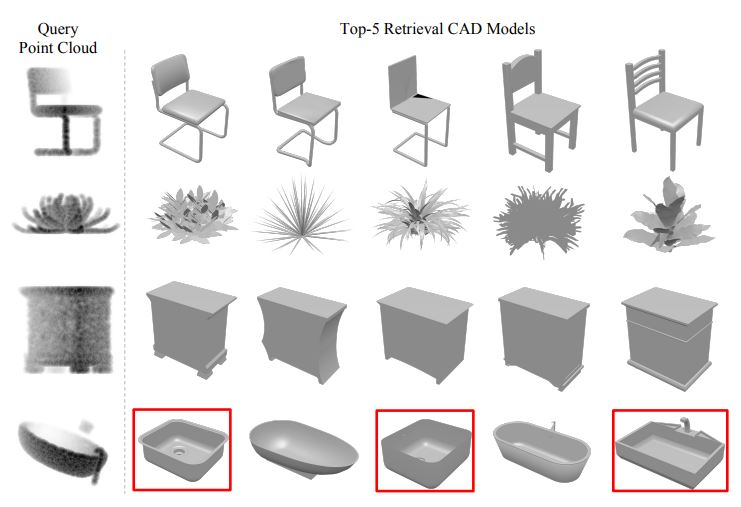

In [24]:
Image('tmp/similar_shapes.jpg')

В данном разделе повторим этот опыт. 

Для начала сформируем базу данных тестовых объектов в виде следующего словаря:

```{
  object_id: {
      'pcd_path': путь к файлу в формате .off,
      'embedding': эмбеддинг объекта,
      'category_name': название класса объекта,
      'target': код класса объекта,
      'crit_points_idx': номера критических точек в каждой позиции вектора эмбеддинга,
      'pointcloud': предобработанное облако точек,
}
```

In [25]:
val_dataset = PointCloudDataset(root_dir=dataset_root, valid=True)

In [26]:
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
object_database = {}

for figure_idx in tqdm(range(len(val_dataset))):
    figure_data = val_dataset[figure_idx]
    pointcloud = figure_data['pointcloud'].unsqueeze(dim=0).to(device)
    logits, matrix3x3, matrix64x64, embeddings, crit_points_idx = model(pointcloud)
    
    object_embedding = embeddings.cpu().detach().numpy().tolist()[0]
    crit_points_idx = crit_points_idx.cpu().detach().numpy().tolist()
    pointcloud = pointcloud.cpu().detach().numpy().tolist()[0]
    
    object_database[figure_idx] = {}
    object_database[figure_idx]['pcd_path'] = figure_data['pcd_path']
    object_database[figure_idx]['embedding'] = object_embedding
    object_database[figure_idx]['category_name'] = figure_data['category_name']
    object_database[figure_idx]['target'] = figure_data['target']
    object_database[figure_idx]['crit_points_idx'] = crit_points_idx
    object_database[figure_idx]['pointcloud'] = pointcloud

  0%|          | 0/908 [00:00<?, ?it/s]

База object_database сформирована. Теперь обучим модель NearestNeighbors на всем тестовом датасете и для объекта с идентификатором current_object_id найдем ТОП-10 похожих объектов:

In [27]:
current_object_id = 10
current_object_filename = os.path.basename(object_database[current_object_id]['pcd_path'])
current_object_embedding = object_database[current_object_id]['embedding']
current_category_name = object_database[current_object_id]['category_name']

print(f"Объект поиска: {current_object_filename}\n")

X = np.vstack([val['embedding'] for val in object_database.values()])

knn = NearestNeighbors(n_neighbors=10)
knn.fit(X)

neighbors = knn.kneighbors([current_object_embedding], n_neighbors=11, return_distance=False)

coeff = 0
print("ТОП-10 похожих объектов:\n")
for idx, sim_object_idx in enumerate(neighbors[0], 1):
    if current_object_id == sim_object_idx:
        coeff = 1
        continue
    object_filename = os.path.basename(object_database[sim_object_idx]['pcd_path'])
    print(f"{idx-coeff}. {object_filename}")

Объект поиска: bathtub_0117.off

ТОП-10 похожих объектов:

1. bathtub_0140.off
2. bathtub_0155.off
3. bathtub_0115.off
4. bathtub_0142.off
5. bathtub_0150.off
6. bathtub_0143.off
7. bathtub_0148.off
8. bathtub_0118.off
9. bathtub_0151.off
10. bathtub_0156.off


Как видно из результата поиска, мы действительно можем с помощью эмбеддингов модели эффективно находить похожие объекты. Модель предсказала 100 объектов того же самого класса.

### 3.3 Операция shape correspondence критических точек двух объектов

Авторы статьи обнаружили следующую закономерность: если в рамках объектов одинаковых классов взять критические точки, то критические точки на одинаковых позициях слоя global feature будут находится физически примерно на одних и тех же частях объектов. Например, если критическая точка первого объекта находится в первой позиции эмбеддинга и она физически располагается на ножке стула, то и критическая точка второго объекта стула в первой позиции эмбеддинга будет находиться примерно там же.

Ниже приведена иллюстрация из статьи, в которой авторы берут 20 случайных критических точек на двух объектах в одинаковых позициях эмбеддинга и соединяют их линиями.

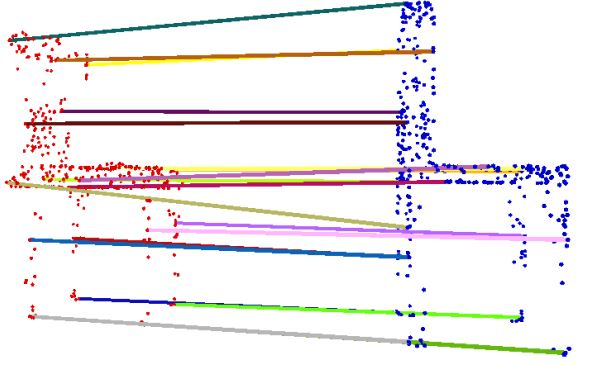

In [28]:
Image('tmp/shape_correspondence.jpg')

В данном разделе повторим этот опыт на наших тестовых данных.

Для этого возьмем 2 объекта из одной категории category_id:

In [29]:
category_id = 2

all_category_object_ids = [object_id for object_id, object_date in object_database.items() 
                           if object_date['target'] == category_id]

In [30]:
category_object_1 = deepcopy(object_database[all_category_object_ids[0]])
category_object_2 = deepcopy(object_database[all_category_object_ids[15]])

category_object_1['pointcloud'] = np.array(category_object_1['pointcloud'])
category_object_2['pointcloud'] = np.array(category_object_2['pointcloud'])

category_object_1['crit_points_idx'] = np.array(category_object_1['crit_points_idx'])
category_object_2['crit_points_idx'] = np.array(category_object_2['crit_points_idx'])

Визуализируем в 3D наши объекты, это два разных стула:

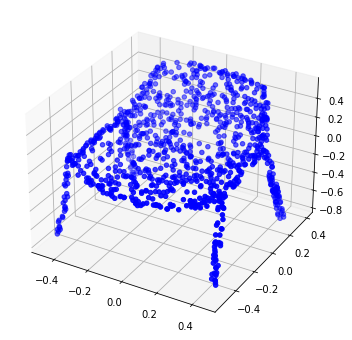

In [31]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(category_object_1['pointcloud'][:,0], category_object_1['pointcloud'][:, 1], 
           category_object_1['pointcloud'][:, 2], c='b')
plt.show()

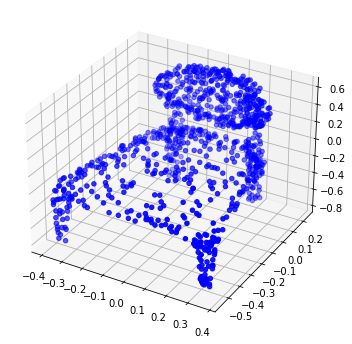

In [32]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(category_object_2['pointcloud'][:,0], category_object_2['pointcloud'][:, 1], 
           category_object_2['pointcloud'][:, 2], c='b')
plt.show()

А теперь пройдемся по эмбеддингам двух объектов и соединим 20 случайных критических точек на одной и той же позиции ембеддингов:

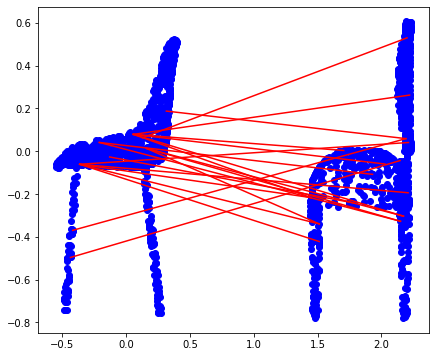

In [33]:
n_links = 20

plt.figure(figsize=(7,6))
plt.scatter(category_object_1['pointcloud'][:, 1], category_object_1['pointcloud'][:, 2], c='b')
plt.scatter(category_object_2['pointcloud'][:, 1]+2, category_object_2['pointcloud'][:, 2], c='b')

for crit_point_idx in np.random.randint(0, len(category_object_1['crit_points_idx'])-1, n_links):
    
    crit_point_idx_object_1 = category_object_1['crit_points_idx'][crit_point_idx]
    crit_point_idx_object_2 = category_object_2['crit_points_idx'][crit_point_idx]
    
    crit_point_object_1 = category_object_1['pointcloud'][crit_point_idx_object_1].copy()
    crit_point_object_2 = category_object_2['pointcloud'][crit_point_idx_object_2].copy()
    crit_point_object_2[1] += 2
    
    stacked_points = np.vstack([crit_point_object_1, crit_point_object_2])
    
    plt.plot(stacked_points[:, 1], stacked_points[:, 2], c='r')

plt.show()

Из результата видно, что полученные связи не такие идеальные, как в статье. Это можно объяснить тем, что для более лучших связей может потребоваться более точное обучение модели.

# ИТОГИ

В данной домашней работе обучили классификационную часть модели PointNet и получили результат accuracy score 0.884 и получили диагональную матрицу ошибок.

Были найдены и визуализированы критические точки. Удалось находить похожие объекты по их эмбеддингам и визуализировали связи между критическими точками разных объектов в рамках одного класса.